In [6]:
from data_processing import load_data
from datetime import datetime
import pandas as pd
import json

In [11]:
#loading the original dataset
df = load_data('../data')
#mapping AreaID values to their meaning
#load the dictionary
AreaID_dict = "../data/AreaID_dict.json"
with open(AreaID_dict, 'r') as file:
    AreaID_dict = json.load(file)

#mapping the df\
df2 = df.copy()
df2['AreaID'] = df2['AreaID'].map(AreaID_dict)
df2['Country'] = df2['AreaID'].str.extract(r'\((.*?)\)')
# Drop the original 'AreaID' column
df2.drop('AreaID', axis=1, inplace=True)
#dropping 'UnitName' as it's useless and rearranging the columns\
df3 = df2[['StartTime','EndTime','Country','PsrType','Load','quantity']]

#Replace NaN values with 0
df3[['Load', 'PsrType', 'quantity']] = df3[['Load', 'PsrType', 'quantity']].fillna(0)

#Filtering by green_energy PsrType
df3 = df3[df3['PsrType'].isin(["B01", "B09", "B10", "B11", "B12","B13", "B15", "B16", "B18", "B19", 0])]
df3.drop('PsrType', axis=1, inplace=True)

/var/folders/2q/wnf6ttl1343fw9wvfvznftw0_zknrv/T/ipykernel_31809/3453462453.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[['Load', 'PsrType', 'quantity']] = df3[['Load', 'PsrType', 'quantity']].fillna(0)


In [12]:
#WORKING ON TIME COLUMNS 
#in order to do so we will separate Load and quantity into different dataframes (we'll rejoin them later)
dfLoad = df3[['StartTime','EndTime','Country','Load']].groupby(['StartTime','EndTime','Country']).sum().reset_index()
dfQuantity = df3[['StartTime','EndTime','Country','quantity']].groupby(['StartTime','EndTime','Country']).sum().reset_index()

#function to simplify code
def hourly_arrange(df0, metric):
    # Convert to datetime
    df0["StartTime"] = pd.to_datetime(df0["StartTime"], format="%Y-%m-%dT%H:%M%zZ")
    df0["EndTime"] = pd.to_datetime(df0["EndTime"], format="%Y-%m-%dT%H:%M%zZ")

    # Set the index to 'StartTime' or 'EndTime'
    df0.set_index('StartTime', inplace=True)

    # Create a new DataFrame for each Country to work the time rows separately and avoid the interpolate() function mix btween Countries\
    grouped = df0.groupby('Country')

    # Resample and interpolate\
    resampled_dfs = []
    for name, group in grouped:
        # Resample to hourly frequency, interpolate, and sum Load values\
        resampled_df = group.resample('H').sum().interpolate()
        
        # Add the 'Country' information back to the resampled DataFrame\
        resampled_df['Country'] = name
        
        resampled_dfs.append(resampled_df)

    # Concatenate the resampled DataFrames\
    df0= pd.concat(resampled_dfs).reset_index()

    return df0
#applying the function to dfLoad and dfQuantity\
dfLoad = hourly_arrange(dfLoad, 'Load')
dfQuantity = hourly_arrange(dfQuantity, 'quantity')
#merging dfLoad and dfQuantity dataframes\
df4 = pd.merge(dfLoad, dfQuantity, on=['StartTime', 'Country'], how='outer')
df4.fillna(0, inplace=True)
#rearranging and renaming columns\
df4 = df4[['StartTime','Country','Load','quantity']]
df4.rename(columns={'Load':'load'}, inplace=True)

/var/folders/2q/wnf6ttl1343fw9wvfvznftw0_zknrv/T/ipykernel_31809/4208703060.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = group.resample('H').sum().interpolate()
/var/folders/2q/wnf6ttl1343fw9wvfvznftw0_zknrv/T/ipykernel_31809/4208703060.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = group.resample('H').sum().interpolate()
/var/folders/2q/wnf6ttl1343fw9wvfvznftw0_zknrv/T/ipykernel_31809/4208703060.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78845 entries, 0 to 78844
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   StartTime  78845 non-null  datetime64[ns, UTC]
 1   Load       78845 non-null  float64            
 2   Country    78845 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78845 entries, 0 to 78844
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   StartTime  78845 non-null  datetime64[ns, UTC]
 1   quantity   78845 non-null  float64            
 2   Country    78845 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 1.8+ MB


/var/folders/2q/wnf6ttl1343fw9wvfvznftw0_zknrv/T/ipykernel_31809/4208703060.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = group.resample('H').sum().interpolate()
/var/folders/2q/wnf6ttl1343fw9wvfvznftw0_zknrv/T/ipykernel_31809/4208703060.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = group.resample('H').sum().interpolate()
/var/folders/2q/wnf6ttl1343fw9wvfvznftw0_zknrv/T/ipykernel_31809/4208703060.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numer

In [21]:
#calculating surplus column
df4['surplus'] = df4['quantity'] - df4['load']
df4.reset_index(inplace=True)

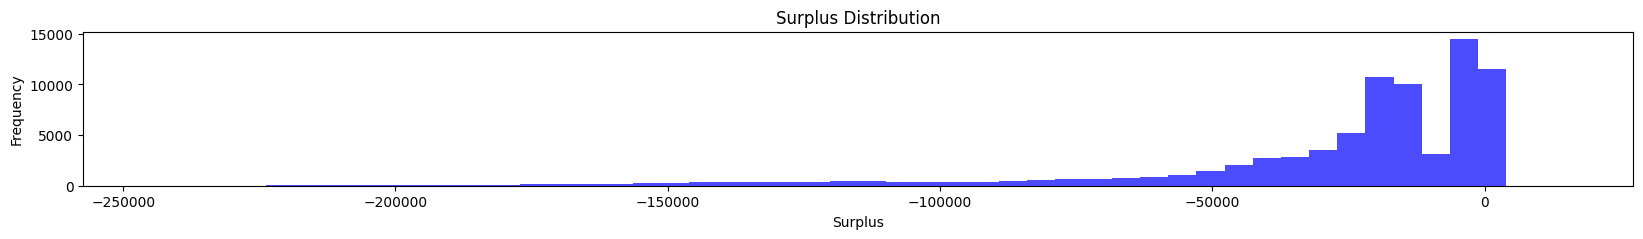

In [34]:
import matplotlib.pyplot as plt

# Assuming df4 is your DataFrame
plt.figure(figsize=(20, 2))
plt.hist(df4['surplus'], bins=50, color='blue', alpha=0.7)
plt.title('Surplus Distribution')
plt.xlabel('Surplus')
plt.ylabel('Frequency')
plt.show()

<AxesSubplot: xlabel='surplus', ylabel='Country'>

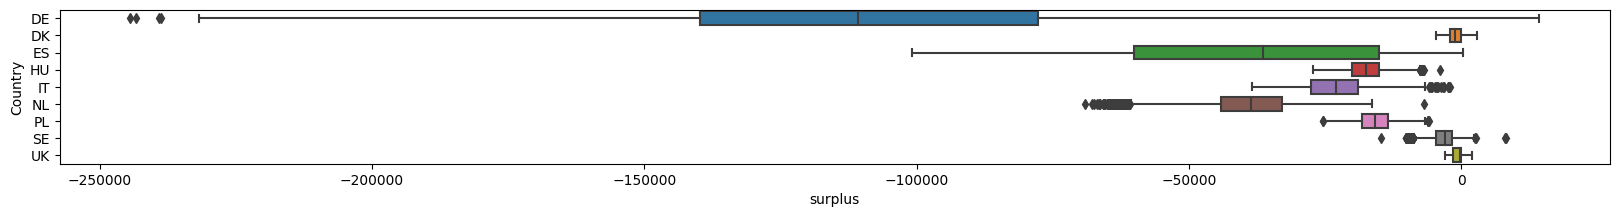

In [36]:
import seaborn as sns

plt.figure(figsize=(20, 2))
sns.boxplot(data=df4, x='surplus', y='Country')